In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json, os

In [26]:
models = [
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_m3d_M3dSegmentation/", "M3dNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_OctreeNCASegmentation/", "OctreeNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostateNN_lossweight_OctreeNCASegmentation/", "OctreeNCANN"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostateAbl_none_10_1.0_20_OctreeNCASegmentation/", "OctreeNCAnew"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_efficientnet-b0_0_MinUNetSegmentation/", "UNet2D Efficientnet"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_mobilenet_v2_0_MinUNetSegmentation/", "UNet2D Mobilenetv2"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_resnet18_0_MinUNetSegmentation/", "UNet2D Resnet18"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_vgg11_0_MinUNetSegmentation/", "UNet2D VGG11"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet_UNetSegmentation/", "UNet3D"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unetXXXS_UNetSegmentation/", "UNet3D XXXS"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet4XS_UNetSegmentation/", "UNet3D 4XS"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_resnet18_0_minUNet3DSegmentation/", "UNet3D Resnet18"),
]

In [27]:
annnotation_list = []
all_files = []
for i, (model, model_name) in enumerate(models):
    score = pd.read_csv(f"{model}eval/standard.csv", sep='\t').loc[:, "DiceScore/0"] * 100

    score_std = score.std()
    score = score.mean()

    mem_allocation = json.load(open(f"{model}/mem_allocation.json"))["byte"]
    num_params = json.load(open(f"{model}/num_params.json"))["num_params"]

    eval_file = {}

    eval_file["model"] = model
    eval_file["mem_allocation"] = mem_allocation
    eval_file["num_params"] = num_params
    eval_file["score"] = score
    eval_file["score_std"] = score_std
    df = pd.DataFrame(index=[i], data=eval_file)
    all_files.append(df)
    annnotation_list.append((num_params, score, model_name))

all_files = pd.concat(all_files)

In [28]:
def get_nnUNet_results(path: str, trainer: str) -> dict:
    FOLD = 0
    TRAIN_TASK = "Task506_Prostate_MEDSeg_split"
    EVAL_TASK = "Task508_Prostate_MEDSeg_split"

    eval_path = os.path.join(path,"evaluation", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/head_None/fold_{FOLD}",EVAL_TASK,
                             "val_metrics_all.csv")
    
    results_path = os.path.join(path, "results", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/fold_{FOLD}")

    results = pd.read_csv(eval_path, sep='\t')
    results = results[results["split"] == "test"]
    results = results[results["seg_mask"] == "mask_1"]
    results = results[results["metric"] == "Dice"]
    ret = {
        "model": trainer,
        "mem_allocation": json.load(open(os.path.join(results_path, "mem_allocation.json")))["byte"],
        "num_params": json.load(open(os.path.join(results_path, "num_params.json")))["num_params"],
        "score": results["value"].mean() * 100,
        "score_std": (results["value"] * 100).std()
    }
    return ret

In [29]:
nnOctreeNCA = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerNCA")
#nnUNet = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerSequential")
data = [nnOctreeNCA]
df = pd.DataFrame(index= [0,1], data=data)
all_files = pd.concat([all_files, df])
for model_d in data:
    annnotation_list.append((model_d["num_params"], model_d["score"], model_d["model"]))

In [30]:
from IPython.display import display, HTML
display(HTML(all_files.to_html()))

,model,mem_allocation,num_params,score,score_std
0,/local/scratch/clmn1/octree_study_new/Experiments/prostate_m3d_M3dSegmentation/,15401065984,12480,80.517897,2.590593
1,/local/scratch/clmn1/octree_study_new/Experiments/prostate_OctreeNCASegmentation/,2499263488,18560,81.442967,1.431956
2,/local/scratch/clmn1/octree_study_new/Experiments/prostateNN_lossweight_OctreeNCASegmentation/,1331218944,17920,82.096144,4.130474
3,/local/scratch/clmn1/octree_study_new/Experiments/prostateAbl_none_10_1.0_20_OctreeNCASegmentation/,3278899200,33300,82.448114,7.207598
4,/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet_UNetSegmentation/,8363604480,19071297,84.063721,6.340254
5,/local/scratch/clmn1/octree_study_new/Experiments/prostate_unetXXXS_UNetSegmentation/,1993954816,287185,79.512108,5.449692
6,/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet4XS_UNetSegmentation/,1007808512,72009,78.541274,6.023142
7,/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_resnet18_0_minUNet3DSegmentation/,4614624768,42611121,85.619158,3.735631
0,nnUNetTrainerNCA,20156209664,21888,83.453555,7.420139
1,nnUNetTrainerNCA,20156209664,21888,83.453555,7.420139


Text(0.5, 1.0, 'Prostate segmentation')

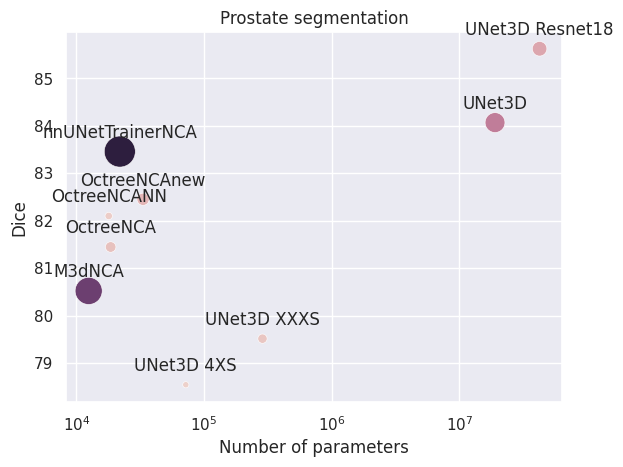

In [31]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="mem_allocation",legend=False, sizes=(20, 500))
for x,y,txt in annnotation_list:
    pass
    ax.annotate(txt, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("Dice")
plt.title("Prostate segmentation")
#plt.ylim(0, 1)

In [32]:
annnotation_list

[(12480, 80.51789658410209, 'M3dNCA'),
 (18560, 81.44296748297555, 'OctreeNCA'),
 (17920, 82.09614413125175, 'OctreeNCANN'),
 (33300, 82.44811381612506, 'OctreeNCAnew'),
 (19071297, 84.063720703125, 'UNet3D'),
 (287185, 79.51210822377887, 'UNet3D XXXS'),
 (72009, 78.54127373014178, 'UNet3D 4XS'),
 (42611121, 85.61915840421405, 'UNet3D Resnet18'),
 (21888, 83.45355537905039, 'nnUNetTrainerNCA')]